In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import PIL
import shutil


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
import matplotlib.pyplot as plt

E0000 00:00:1741047514.484679      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


In [10]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    print("TPU detected:", tpu.master())
except ValueError:
    print("No TPU detected.")

No TPU detected.


# Data Loading

In [4]:

import os

# Define dataset paths
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to load and decode images
def load_jpeg_images(path):
    image_files = tf.io.gfile.glob(path + "/*.jpg")  # Get all image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_files)

    # Function to load and decode an image
    def load_and_preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG (RGB)
        image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
        return image

    dataset = dataset.map(load_and_preprocess_image)  # Apply function
    return dataset

# Load datasets
monet_ds = load_jpeg_images(monet_path)
photo_ds = load_jpeg_images(photo_path)

# Print a sample image shape
for img in monet_ds.take(1):
    print("Image shape:", img.shape)


Image shape: (256, 256, 3)


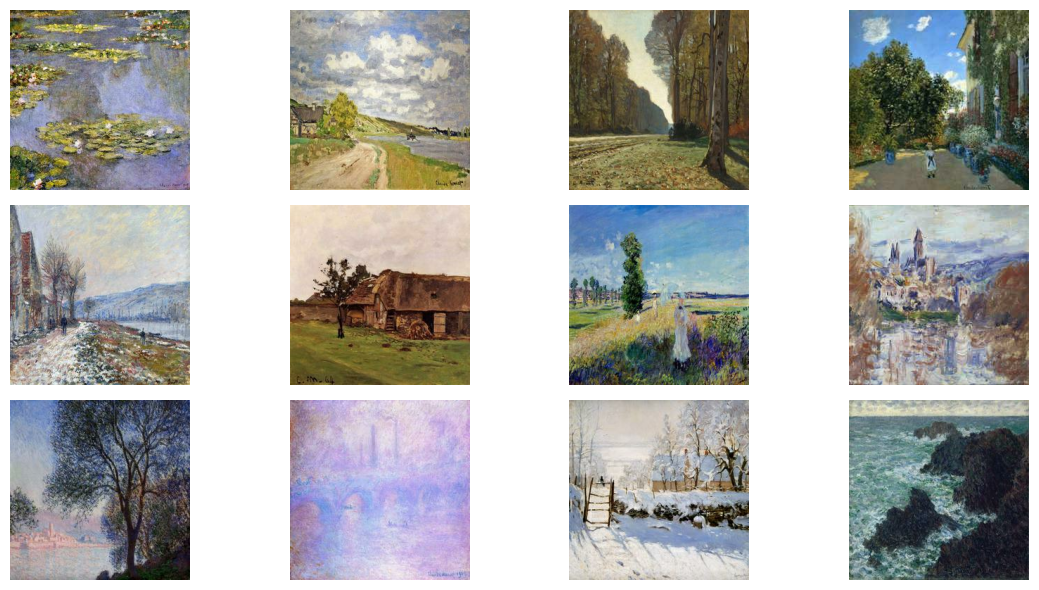

In [5]:
# Plot the first 12 images
plt.figure(figsize=(12, 6))
for i, img in enumerate(monet_ds.take(12)):
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    plt.imshow(img.numpy())  # Convert tensor to numpy array
    plt.axis("off")

plt.tight_layout()
plt.show()

# EDA

In [6]:

# Count number of images in each dataset
num_monet = len(os.listdir(monet_path))
num_photos = len(os.listdir(photo_path))

print(f"Number of Monet paintings: {num_monet}")
print(f"Number of real photos: {num_photos}")


Number of Monet paintings: 300
Number of real photos: 7038


In [7]:

# Load a single image to check its shape
sample_monet = next(iter(monet_ds.take(1))).numpy()
sample_photo = next(iter(photo_ds.take(1))).numpy()

print(f"Monet Image Shape: {sample_monet.shape}")
print(f"Photo Image Shape: {sample_photo.shape}")

Monet Image Shape: (256, 256, 3)
Photo Image Shape: (256, 256, 3)


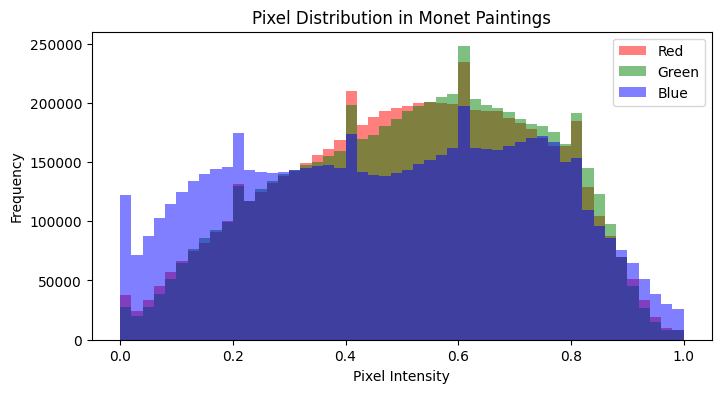

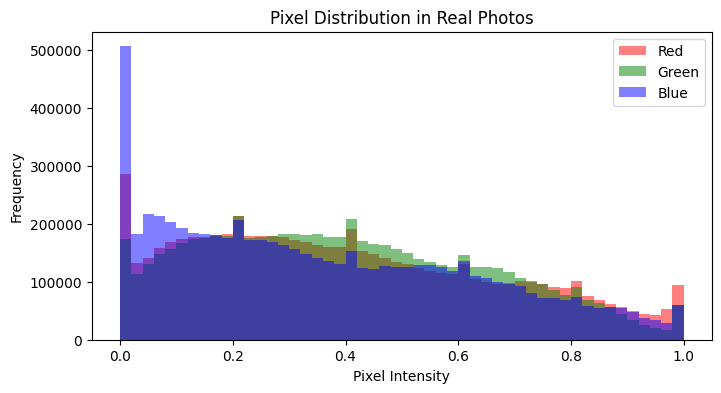

In [9]:

def plot_pixel_distribution(dataset, title):
    all_pixels_r, all_pixels_g, all_pixels_b = [], [], []

    for img in dataset.take(100):  # Sample 100 images
        img = img.numpy()
        all_pixels_r.extend(img[:, :, 0].flatten())  # Red channel
        all_pixels_g.extend(img[:, :, 1].flatten())  # Green channel
        all_pixels_b.extend(img[:, :, 2].flatten())  # Blue channel

    plt.figure(figsize=(8, 4))
    plt.hist(all_pixels_r, bins=50, color='red', alpha=0.5, label="Red")
    plt.hist(all_pixels_g, bins=50, color='green', alpha=0.5, label="Green")
    plt.hist(all_pixels_b, bins=50, color='blue', alpha=0.5, label="Blue")
    
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot pixel distributions for Monet paintings and real photos
plot_pixel_distribution(monet_ds, "Pixel Distribution in Monet Paintings")
plot_pixel_distribution(photo_ds, "Pixel Distribution in Real Photos")
